# Tools comparison
This notebook shows how the comparison between tools has been carried out in PanDelos-frags paper.

In [61]:
# import packages
import os
import numpy as np
import pandas as pd 
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import subprocess

The following four functions are used to read in the output files of the tools and uniform their output into a dataframe with the number of gene families identified and their sizes.

In [62]:
def get_PANPROVA_gfs(ipanprova):
    gf_sizes_prova = dict()
    for line in open(ipanprova,'r'):
        cc = line.strip().split(' ')[1:]
        
        genomes = set()
        for c in cc:
            genome = c.split(',')[0].lstrip('(')
            genomes.add(genome)

        size = len(genomes)
        if size in gf_sizes_prova:
            gf_sizes_prova[size] +=1
        else:
            gf_sizes_prova[size] =1


    prova_pres_abs= pd.DataFrame.from_dict(gf_sizes_prova,orient='index')
    prova=prova_pres_abs.rename(columns={prova_pres_abs.columns[0]:'PanProva'})
    prova['GF Size']=prova.index
    return prova

In [63]:
def get_pandelos_gfs(delos_pres_abs):
    gf_sizes_delos = dict() 

    with open(delos_pres_abs) as f:
            lines = f.readlines()

    for l in lines: 
        l = l.rstrip()
        l = l.split(' ')
        genome_set = set()
        selected_genes = []
        for gene in l:
            genome = gene.split(':')[0]

            if genome in genome_set:
                continue
            else:
                genome_set.add(genome)
                selected_genes.append(gene)

        
        if len(genome_set) in gf_sizes_delos.keys():
            gf_sizes_delos[len(genome_set)] += 1
        else:
            gf_sizes_delos[len(genome_set)] = 1

    delos_pres_abs= pd.DataFrame.from_dict(gf_sizes_delos,orient='index')
    delos=delos_pres_abs.rename(columns={delos_pres_abs.columns[0]:'PanDelos-frags'})
    delos['GF Size']=delos.index
    return delos

In [64]:
def get_roary_gfs(roary_pres_abs):
    roary = Counter(roary_pres_abs['No. isolates'])
    roary=pd.DataFrame.from_dict(roary,orient='index')
    roary=roary.rename(columns={roary.columns[0]:'Roary'})
    roary['GF Size'] = roary.index
    return roary

In [65]:
def gene_pres_abs_processing(pres_abs,tool,n,empty):
    count = dict()
    for i in pres_abs.index:
        genes=pres_abs.iloc[i,n:].values
        genes=[g for g in genes if g != empty]

             
        if len(genes) in count.keys():
            count[len(genes)] += 1
        else:
            count[len(genes)] = 1

    df=pd.DataFrame.from_dict(count,orient='index')
    df=df.rename(columns={df.columns[0]:tool})
    df['GF Size'] = df.index
    return df

## 1)Synthetic data

In [66]:
# For all fragmentation levels
frags=['0.5','0.6','0.7','0.8','0.9','1']

# This can be computed for all 3 species under analysis
species = 'synth_ecoli' # synth_myco synth_paeru

The following function is used to compute homology f1-scores. This can only be applied to synthetic benchmark as it requries a ground truth (in this case PANPROVA gene families) to be compared to.

In [67]:
# Function used to compute homology f1-scores. 
def f1_calculator(species, tools, frags=['0.5','0.6','0.7','0.8','0.9','1'], coverage='50'):
    directory_path = os.getcwd()
    coverage=str(coverage)
    identity=str(identity)

    first=True
    res=pd.DataFrame(columns=frags)
    display(res)
    for tool in tools:
         
        genes_tool = list()
        mapping_genes_tool = list()
        homo_tool = list()
        mapping_homo_tool = list()
        f1_tool = list()
        prova_genes = list()
        prova_homo = list()
                
        for fragmentation in frags: 

            if tool=='Roary':
                itool = directory_path+'/synth_'+species+'/'+fragmentation+'/'+tool+'/output/clustered_proteins'
                imap = directory_path+'/PANPROVA_'+species+'/mappings/qcov_'+coverage+'/'+tool+'_'+fragmentation+'_bbmapping.csv'

            elif tool=='PanDelos':
                itool = directory_path+'/synth_'+species+'/'+fragmentation+'/'+tool+'/output/output.clus'
                imap = directory_path+'/PANPROVA_'+species+'/mappings/qcov_'+coverage+'/'+tool+'_'+fragmentation+'_bbmapping.csv'
 
            elif tool=='Panaroo':
                itool = directory_path+'/synth_'+species+'/'+fragmentation+'/'+tool+'/gene_presence_absence.csv'
                imap = directory_path+'/PANPROVA_'+species+'/mappings/qcov_'+coverage+'/Roary_'+fragmentation+'_bbmapping.csv'


            elif tool=='GenAPI':
                itool = directory_path+'/synth_'+species+'/'+fragmentation+'/'+tool+'/clustered_genes_genapi.ffn.clstr'
                imap = directory_path+'/PANPROVA_'+species+'/mappings/qcov_'+coverage+'/Roary_'+fragmentation+'_bbmapping.csv'

            else:
                print('Wrong toolname, has to be one between Roary, PanDelos, Panaroo, and GenAPI. Check your spelling.')

            ipanprova = directory_path+'/PANPROVA_'+species+'/'+fragmentation+'/survival_families'

            prgenes = set()
            rrgenes = set()

            pr2rr = dict()
            rr2pr = dict()

            for line in open(imap,'r'):
                cc = line.strip().split(' ')
                rr = cc[1]
                pr = cc[0]
                
                rrgenes.add(rr)
                prgenes.add(pr)

                if rr not in rr2pr:
                    rr2pr[rr] = pr
                if pr not in pr2rr:
                    pr2rr[pr] = rr

            mapping=len(rr2pr)
 
            prgenes = set()
            prhomos = set()
            for line in open(ipanprova,'r'):
                cc = line.strip().split(' ')
                for i in range(1, len(cc)):
                    prgenes.add(cc[i])
                    for j in range(i+1, len(cc)):
                        prhomos.add( (cc[i],cc[j]) )
                        prhomos.add( (cc[j],cc[i]) ) 
            rrhomos = set()
            rrgenes = set()

            if tool=='GenAPI': 
                cc =list()
                for line in open(itool,'r'): 
                    if not line.startswith('>'):
                        gene = line.split('>')[1].split(':')[0]
                        cc.append(gene)
                    else:
                        for i in range(0, len(cc)):
                            rrgenes.add(cc[i])
                            for j in range(i+1, len(cc)):
                                rrhomos.add( (cc[i],cc[j]) )
                                rrhomos.add( (cc[j],cc[i]) )
                        
                        cc=list()
            else:


                for line in open(itool,'r'): 
                        
                    if tool=='Roary':
                        cc = line.strip().split(':')[1].strip().split('\t')
                    elif tool=='PanDelos':
                        cc = line.strip().split(' ')
                    elif tool=='Panaroo':
                        if line.startswith('Gene'):
                            continue
                        else:
                            cc = line.strip().split(',')[3:]
                            cc=[g.split(';') for g in cc if g != '']
                            cc=list(chain(*cc))

                    for i in range(0, len(cc)):
                        rrgenes.add(cc[i])
                        for j in range(i+1, len(cc)):
                            rrhomos.add( (cc[i],cc[j]) )
                            rrhomos.add( (cc[j],cc[i]) ) 

            tp,tn,fp,fn = 0,0,0,0

            for c in rrhomos:
                if (c[0] in rr2pr) and (c[1] in rr2pr):
                    m = ( rr2pr[c[0]], rr2pr[c[1]] )
                    if m in prhomos:
                        tp += 1
                    else:
                        fp += 1

            for c in prhomos:
                if (c[0] in pr2rr) and (c[1] in pr2rr):
                    m = ( pr2rr[c[0]], pr2rr[c[1]] )
                    if m not in rrhomos:
                        fn += 1

            if tp+fp == 0:
                precision = 0
            else:
                precision = tp/ ( tp + fp )
            
            if tp+fn == 0:
                recall = 0
            else:
                recall = tp / (tp + fn)
            
            if recall == 0 and precision == 0 :
                f1score = 0
            else:
                f1score = 2 * tp / ( (2*tp) + fp + fn )
            
            #fdr = fp / (fp + tp)

            
            genes_tool.append(len(rrgenes))
            mapping_genes_tool.append(int(mapping))
            homo_tool.append(len(rrhomos))
            mapping_homo_tool.append(int(tp)+int(fn))
            f1_tool.append(round(f1score,2))


            if first:
                prova_genes.append(len(prgenes))
                prova_homo.append(len(prhomos))

        if first:
            res = res.append(pd.DataFrame.from_dict({'PanProva genes':prova_genes,
                                                     'PanProva homo': prova_homo},orient='index',columns=frags))
            first=False

                                            
        res = res.append(pd.DataFrame.from_dict({tool+' genes':genes_tool,
                                                tool+' mapping genes':mapping_genes_tool,
                                                tool+' homo': homo_tool,
                                                tool+' mapping homo':mapping_homo_tool,
                                                tool+' F1-score mapping homo':f1_tool},orient='index',columns=frags))


        #res.to_csv(directory_path+'/PANPROVA_'+species+'/stats/'+tool+'_perc_id'+identity+'_qcov_'+coverage+'.csv')
    return res

In [68]:
all_tools_l = []
for fragmentation in frags:
    # set directories
    basedir = os.getcwd()
    delosdir = basedir+'/'+species+'/'+fragmentation+'/PanDelos'
    roarydir = basedir+'/'+species+'/'+fragmentation+'/Roary'

    panaroodir = basedir+'/'+species+'/'+fragmentation+'/Panaroo'
    comparisondir = basedir+'/'+species+'/'+fragmentation+'/Comparison/'
    figdir = basedir+'/paper_figures'
    os.makedirs(figdir,exist_ok=True)

    os.makedirs(comparisondir,exist_ok=True)

    # set files with gene families information
    delos_pres_abs = delosdir+'/output/output.clus'
    roary_pres_abs = pd.read_csv(roarydir+'/output/gene_presence_absence.csv',na_filter=False)
    panaroo_pres_abs = pd.read_csv(panaroodir+'/gene_presence_absence.csv',na_filter=False)
    genapi_pres_abs=pd.read_csv(basedir+'/'+species+'/'+fragmentation+'/GenAPI'+'/gene_presence_absence_genapi.txt',sep='\t')
    ipanprova = basedir+'/PANPROVA_'+species+'/'+fragmentation+'/survival_families' #only if synthetic

    # get gene families into dataframe
    prova= get_PANPROVA_gfs(ipanprova)
    delos = get_pandelos_gfs(delos_pres_abs)
    roary = get_roary_gfs(roary_pres_abs)
    panaroo = gene_pres_abs_processing(panaroo_pres_abs,'panaroo',3,'')
    genapi = gene_pres_abs_processing(genapi_pres_abs,'genapi',1,0)

    # merge all tools dataframe
    all_tools=delos.merge(roary,on='GF Size',how='left')
    all_tools=all_tools.merge(panaroo,on='GF Size',how='left')
    all_tools=all_tools.merge(genapi,on='GF Size',how='left')
    all_tools=all_tools.merge(prova,on='GF Size',how='left')
    all_tools=all_tools.fillna(0)
    all_tools_l.append(all_tools)

/home/claudia/tools/anaconda3/envs/prog4bio/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Absolute percentage difference of core genes 

In [69]:
ploss_tools_l=dict()
ploss_tools_l['PanDelos-frags']=0
ploss_tools_l['Roary']=0
ploss_tools_l['panaroo']=0
ploss_tools_l['genapi']=0

# sum absolute percentage difference of core genes across different fragmentation leveles
for el in all_tools_l:
    ploss_tools_l['PanDelos-frags']+=abs(100*((el.loc[el['GF Size']==10,'PanProva'].values[0] - el.loc[el['GF Size']==10,'PanDelos-frags'].values[0])/el.loc[el['GF Size']==10,'PanProva'].values[0]))
    ploss_tools_l['Roary']+=abs(100*((el.loc[el['GF Size']==10,'PanProva'].values[0] - el.loc[el['GF Size']==10,'Roary'].values[0])/el.loc[el['GF Size']==10,'PanProva'].values[0]))
    ploss_tools_l['panaroo']+=abs(100*((el.loc[el['GF Size']==10,'PanProva'].values[0] - el.loc[el['GF Size']==10,'panaroo'].values[0])/el.loc[el['GF Size']==10,'PanProva'].values[0]))
    ploss_tools_l['genapi']+=abs(100*((el.loc[el['GF Size']==10,'PanProva'].values[0] - el.loc[el['GF Size']==10,'genapi'].values[0])/el.loc[el['GF Size']==10,'PanProva'].values[0]))

# compute average
for k in ploss_tools_l:
    value=ploss_tools_l[k]
    print('Absolute percentage difference of core genes in '+k+': '+str(round(value/6,1)))

Absolute percentage difference of core genes in PanDelos-frags: 12.2
Absolute percentage difference of core genes in Roary: 98.5
Absolute percentage difference of core genes in panaroo: 36.8
Absolute percentage difference of core genes in genapi: 32.6


### Calculate homology F1-scores

#### Map families using BLAST

In [ ]:
# Extract gene sequences of genes that survived through fragmentation (partially or completely)
ret=subprocess.call(['bash',basedir+"panprova_blast_scripts/run_extract_survival_genes.sh",species],stdout=subprocess.DEVNULL)

# BBH between complete gene sequences and fragmented gene sequences to identify correspondance between ground truth (PANPROVA) and tools
ret=subprocess.call(['bash',basedir+"panprova_blast_scripts/run_blast_pandelos.sh",species],stdout=subprocess.DEVNULL)
ret=subprocess.call(['bash',basedir+"panprova_blast_scripts/run_blast_prokka.sh",species],stdout=subprocess.DEVNULL)

In [70]:
# Compute F1-scores
F_ONES= f1_calculator(species, ['PanDelos','Roary','Panaroo','GenAPI'])
F_ONES

,0.5,0.6,0.7,0.8,0.9,1


,0.5,0.6,0.7,0.8,0.9,1
PanProva genes,27437,32813,38049,43361,48884,53534
PanProva homo,151176,202708,258662,321774,394556,468510
PanDelos genes,34698.0,41541.0,48342.0,55123.0,62260.0,69100.0
PanDelos mapping genes,23414.0,27895.0,32234.0,36692.0,41368.0,45614.0
PanDelos homo,163332.0,213902.0,267900.0,329468.0,400454.0,476838.0
PanDelos mapping homo,112786.0,151368.0,194100.0,242898.0,299910.0,363226.0
PanDelos F1-score mapping homo,0.95,0.95,0.96,0.96,0.97,0.97
Roary genes,34358.0,41212.0,47974.0,54728.0,61793.0,68798.0
Roary mapping genes,22565.0,27105.0,31468.0,35937.0,40627.0,45281.0
Roary homo,49942.0,66316.0,83908.0,102648.0,125758.0,153430.0


### Plot diffusivity 

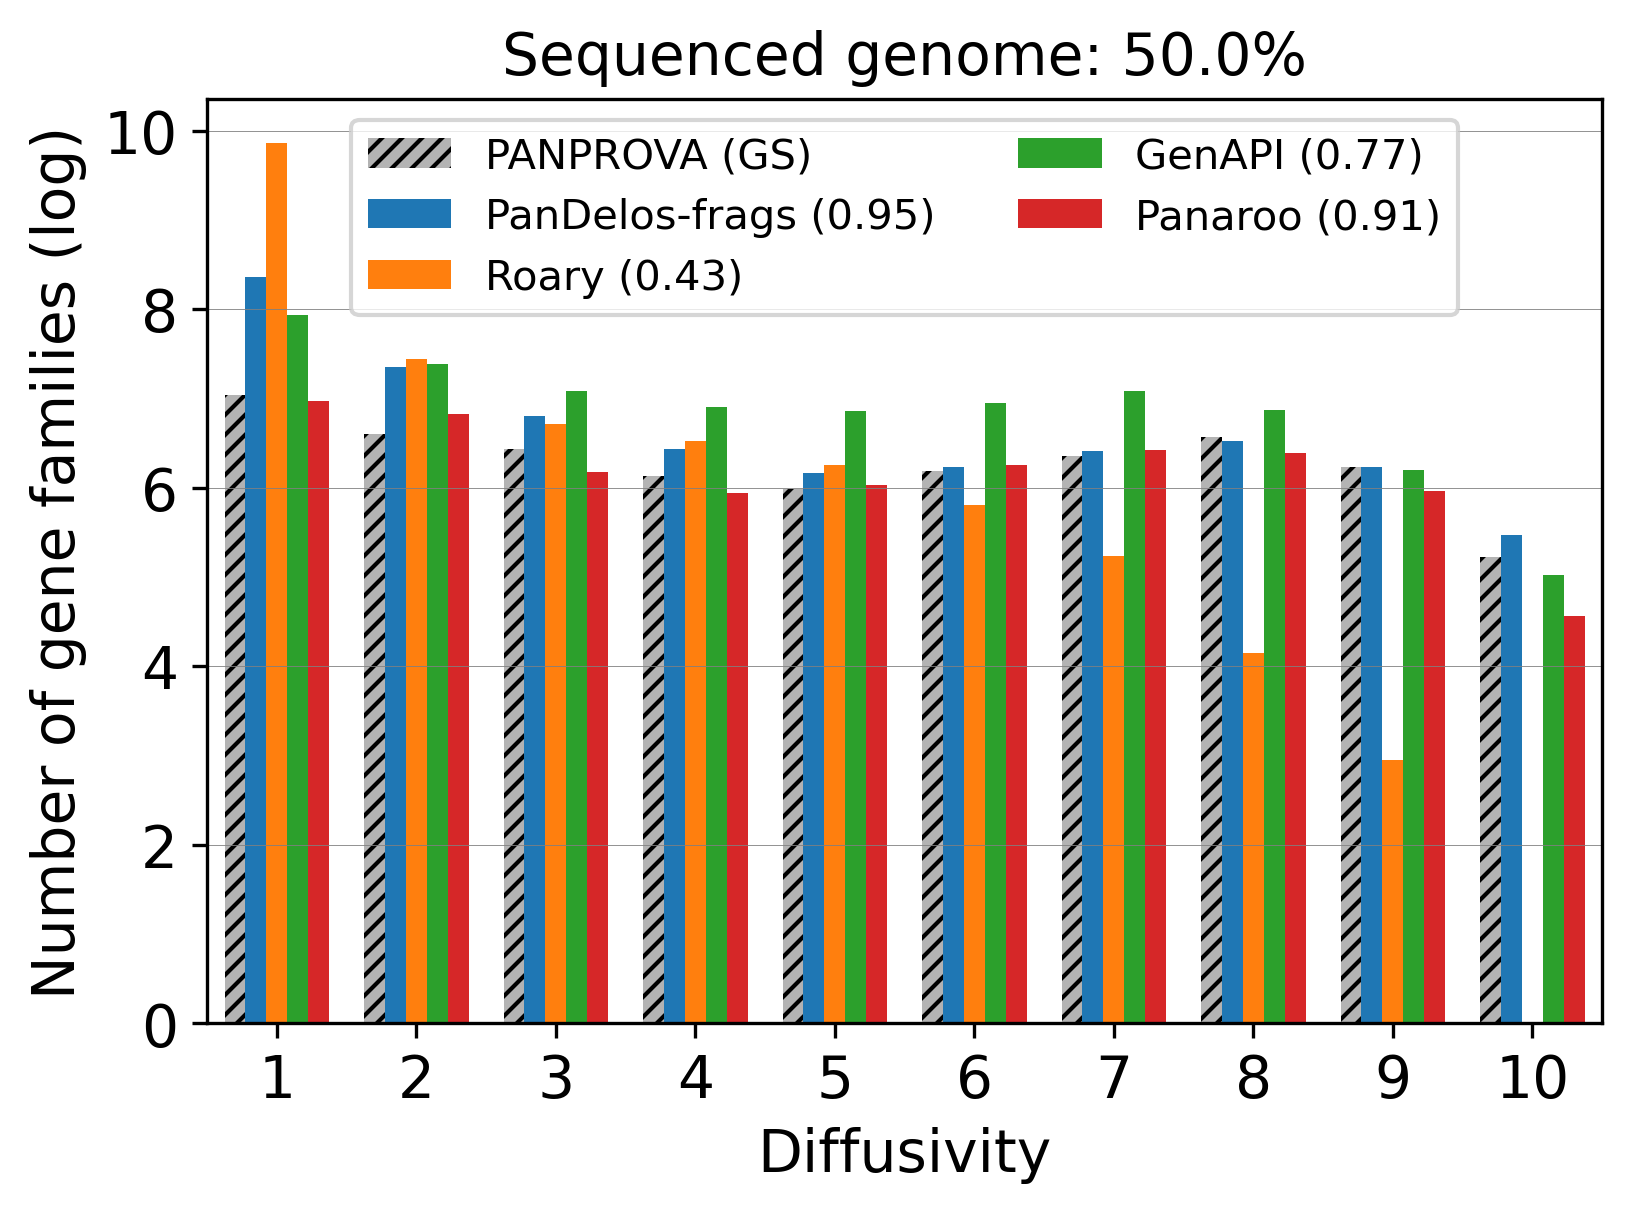

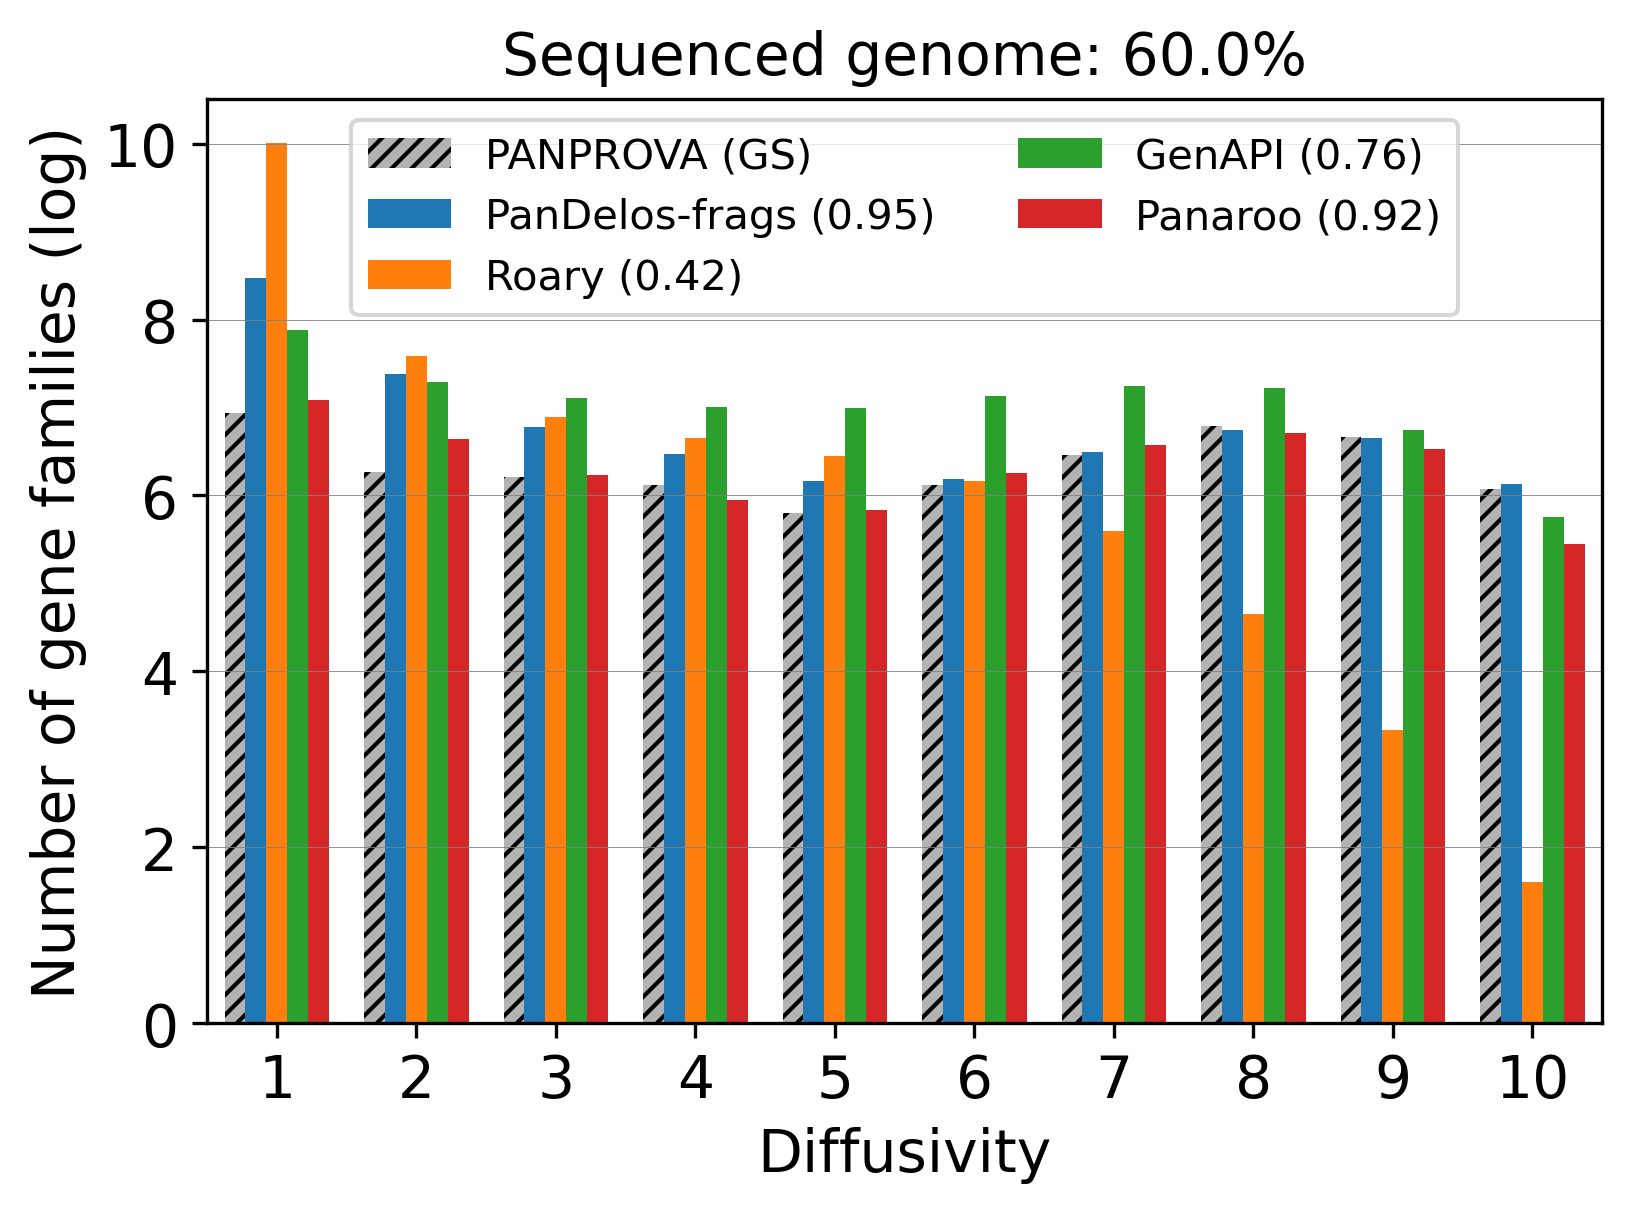

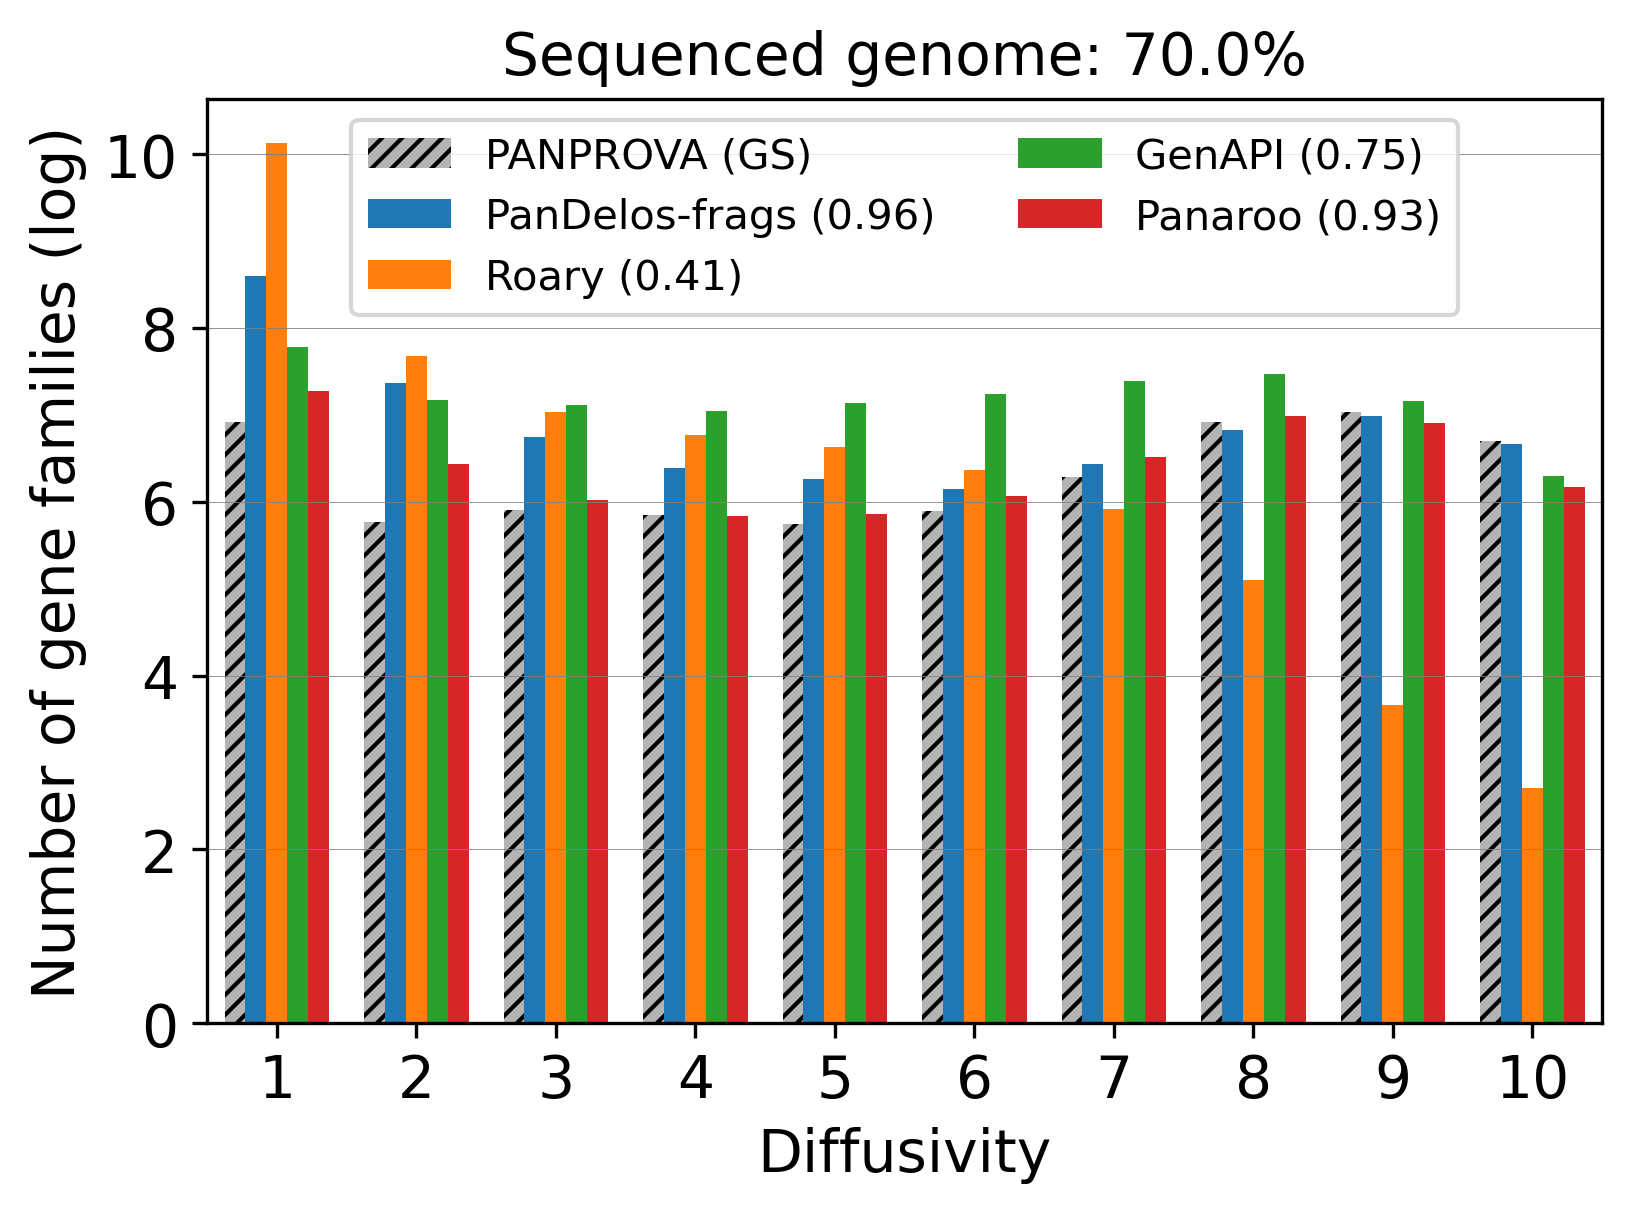

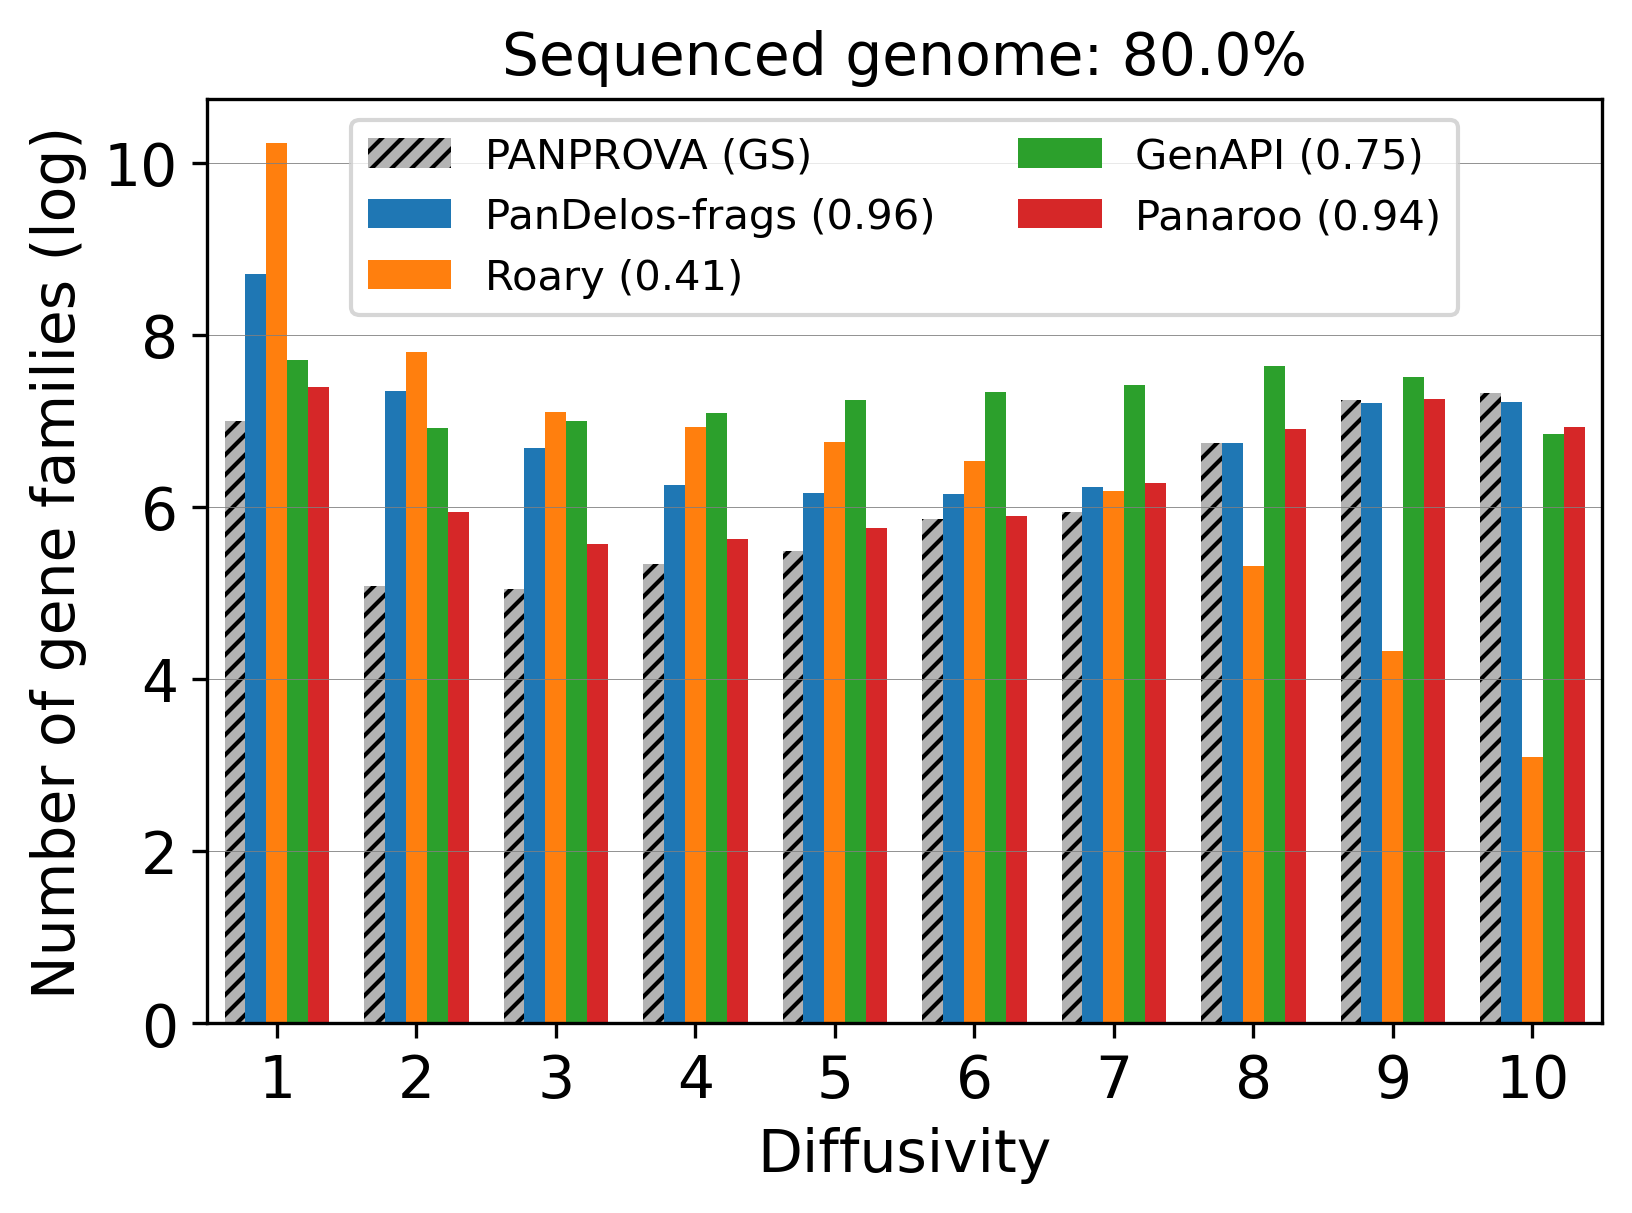

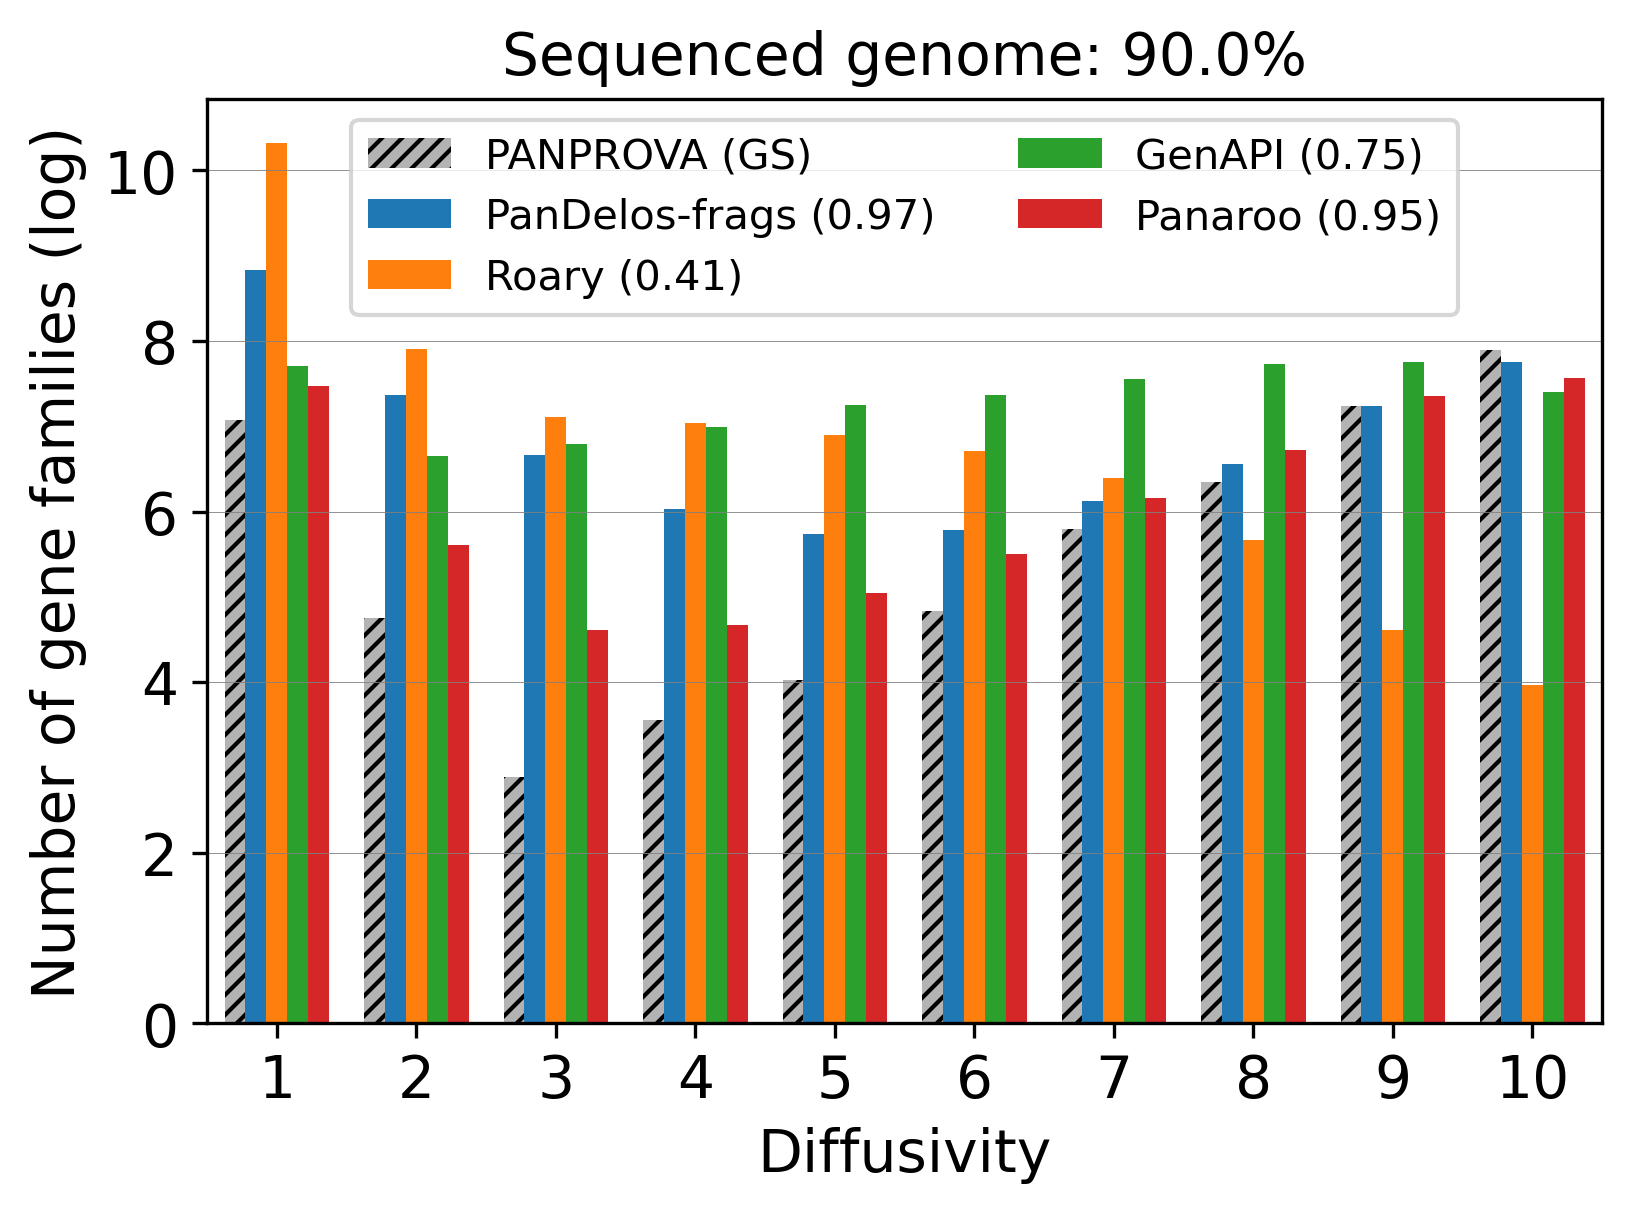

/home/claudia/tools/anaconda3/envs/prog4bio/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


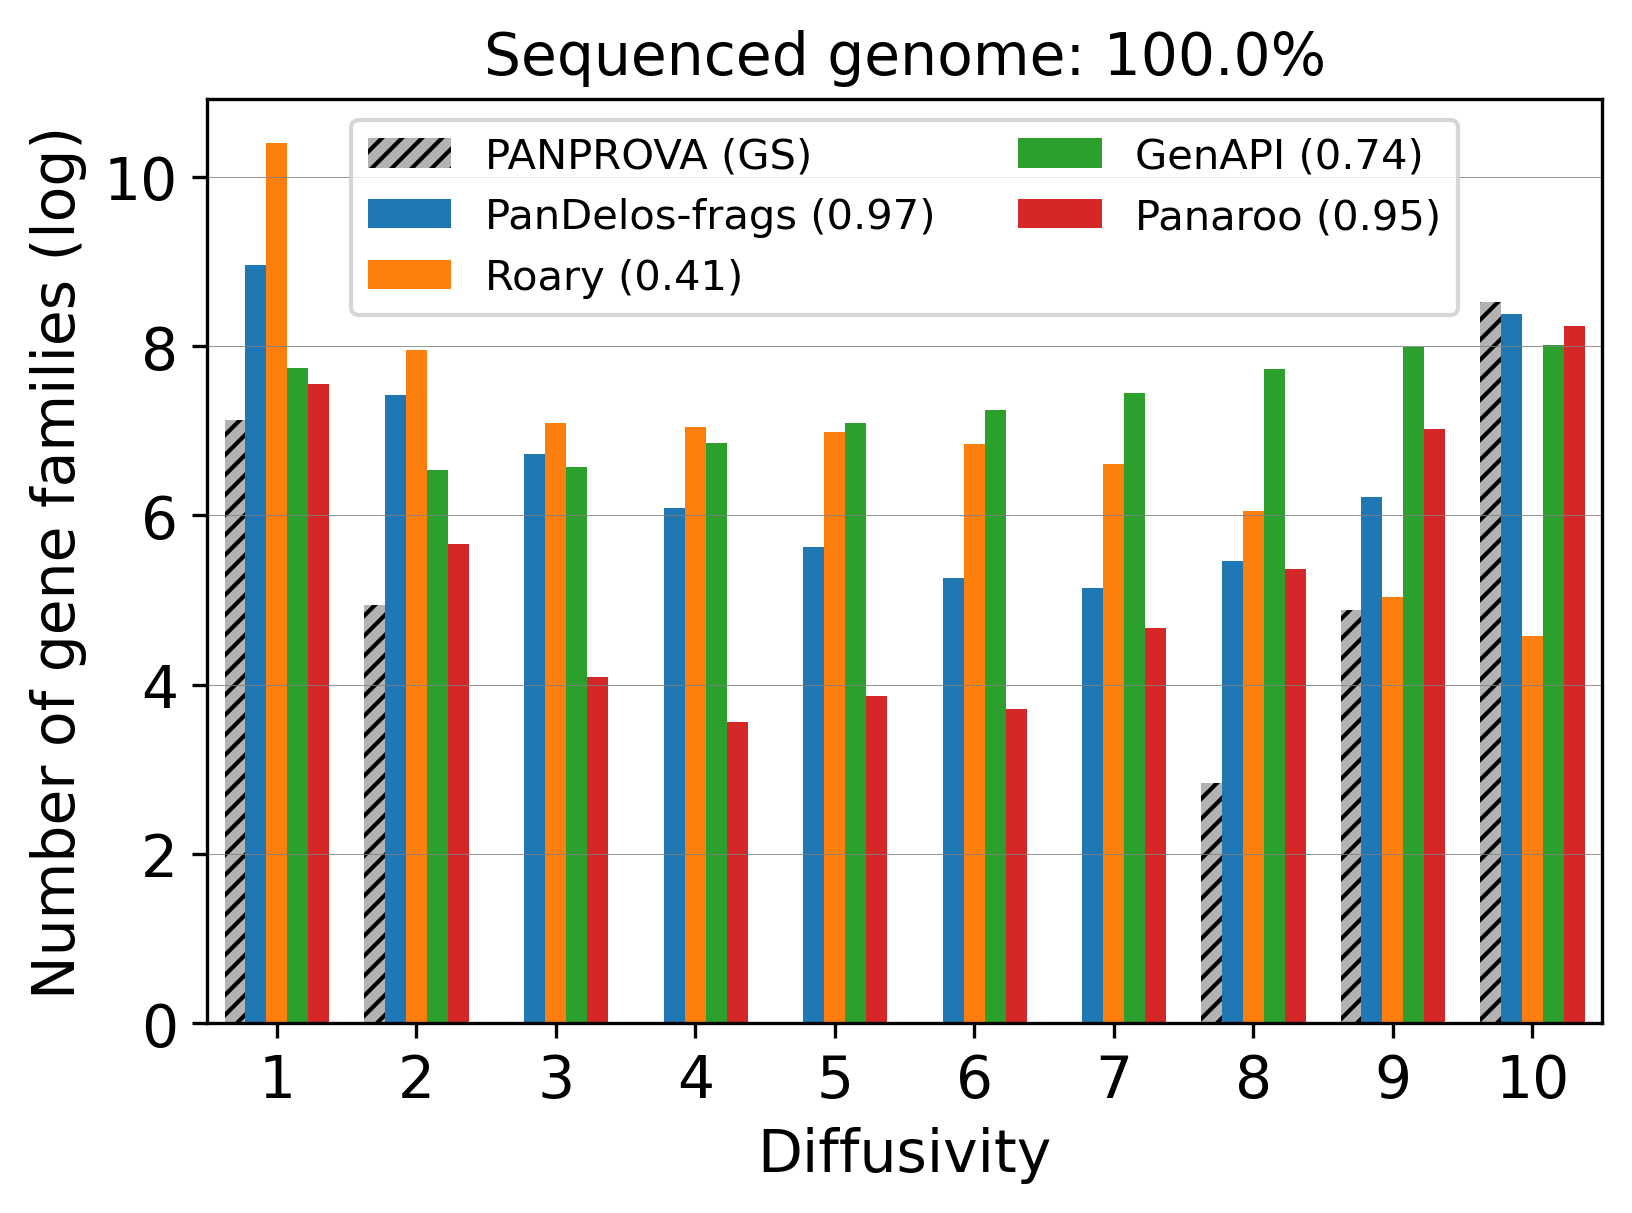

In [71]:
i=0

for all_tools in all_tools_l:
    fragmentation=frags[i]

    # set legend as homology f1-score
    pandelos_score=F_ONES.loc['PanDelos F1-score mapping homo', fragmentation]
    roary_score=F_ONES.loc['Roary F1-score mapping homo', fragmentation]
    panaroo_score=F_ONES.loc['Panaroo F1-score mapping homo',fragmentation]
    genapi_score=F_ONES.loc['GenAPI F1-score mapping homo',fragmentation]

    pandelos_label='PanDelos-frags ('+str(pandelos_score)+')'
    roary_label='Roary ('+str(roary_score)+')'
    panaroo_label='Panaroo ('+str(panaroo_score)+')'
    genapi_label='GenAPI ('+str(genapi_score)+')'
    labs=['PANPROVA (GS)',pandelos_label,roary_label,genapi_label,panaroo_label]

    # graphical paramters
    figsize=(6,4)
    titlee='Sequenced genome: '+ str(float(fragmentation)*100)+'%'

    fig, axe = plt.subplots(figsize=figsize, dpi=300)

    plt.xlabel('Diffusivity',fontsize=14)
    plt.ylabel('Number of gene families (log)',fontsize=14)
    plt.title(titlee,fontsize=14)  
    plt.bar([l-0.3 for l in all_tools['GF Size']],np.log(all_tools['PanProva']),0.15,label='PanProva',color='0.7',hatch='/////') 
    plt.bar([l-0.15 for l in all_tools['GF Size']],np.log(all_tools['PanDelos-frags']),0.15,label='PanDelos-frags') 
    plt.bar([l-0.0 for l in all_tools['GF Size']],np.log(all_tools['Roary']),0.15,label='Roary') 
    plt.bar([l+0.15 for l in all_tools['GF Size']],np.log(all_tools['genapi']),0.15,label='GenAPI') 
    plt.bar([l+0.3 for l in all_tools['GF Size']],np.log(all_tools['panaroo']),0.15,label='Panaroo')  

    plt.grid(True, axis='y', color = "grey", linewidth = "0.2")
    plt.xticks(list(all_tools['GF Size']),list(all_tools['GF Size']),fontsize=14)
    plt.xlim(0.5,max(all_tools['GF Size'])+0.5)
    plt.yticks(fontsize=14) 
    plt.legend(loc='upper center', fancybox=True, ncol=2,labels=labs,fontsize=10)
    plt.show()

    #plt.savefig(figdir+'/'+species+'qcov'+qcov+'_'+fragmentation+'_tools_comparison.png', dpi=300,bbox_inches='tight')
    i+=1


In [72]:
# 2) METAGENOMIC
# This can be computed for all 3 species under analysis
species = 'abiotrophia_defectiva'  #bacteroides_nordii pseudomonas_aeruginosa

# set directories
basedir = os.getcwd()
delosdir = basedir+'/'+species+'/PanDelos'
roarydir = basedir+'/'+species+'/Roary'

panaroodir = basedir+'/'+species+'/Panaroo'
comparisondir = basedir+'/'+species+'/Comparison/'
figdir = basedir+'/paper_figures'
os.makedirs(figdir,exist_ok=True)
os.makedirs(comparisondir,exist_ok=True)

# set files with gene families information
delos_pres_abs = delosdir+'/output/output.clus'
roary_pres_abs = pd.read_csv(roarydir+'/output/gene_presence_absence.csv',na_filter=False)
panaroo_pres_abs = pd.read_csv(panaroodir+'/gene_presence_absence.csv',na_filter=False)
genapi_pres_abs=pd.read_csv(basedir+'/'+species+'/GenAPI'+'/gene_presence_absence_genapi.txt',sep='\t') 

# get gene families into dataframe
prova= get_PANPROVA_gfs(ipanprova)
delos = get_pandelos_gfs(delos_pres_abs)
roary = get_roary_gfs(roary_pres_abs)
panaroo = gene_pres_abs_processing(panaroo_pres_abs,'panaroo',3,'')
genapi = gene_pres_abs_processing(genapi_pres_abs,'genapi',1,0)

# merge all tools dataframe
all_tools=delos.merge(roary,on='GF Size',how='left')
all_tools=all_tools.merge(panaroo,on='GF Size',how='left')
all_tools=all_tools.merge(genapi,on='GF Size',how='left')
all_tools=all_tools.merge(prova,on='GF Size',how='left')
all_tools=all_tools.fillna(0) 


### Plot diffusivity

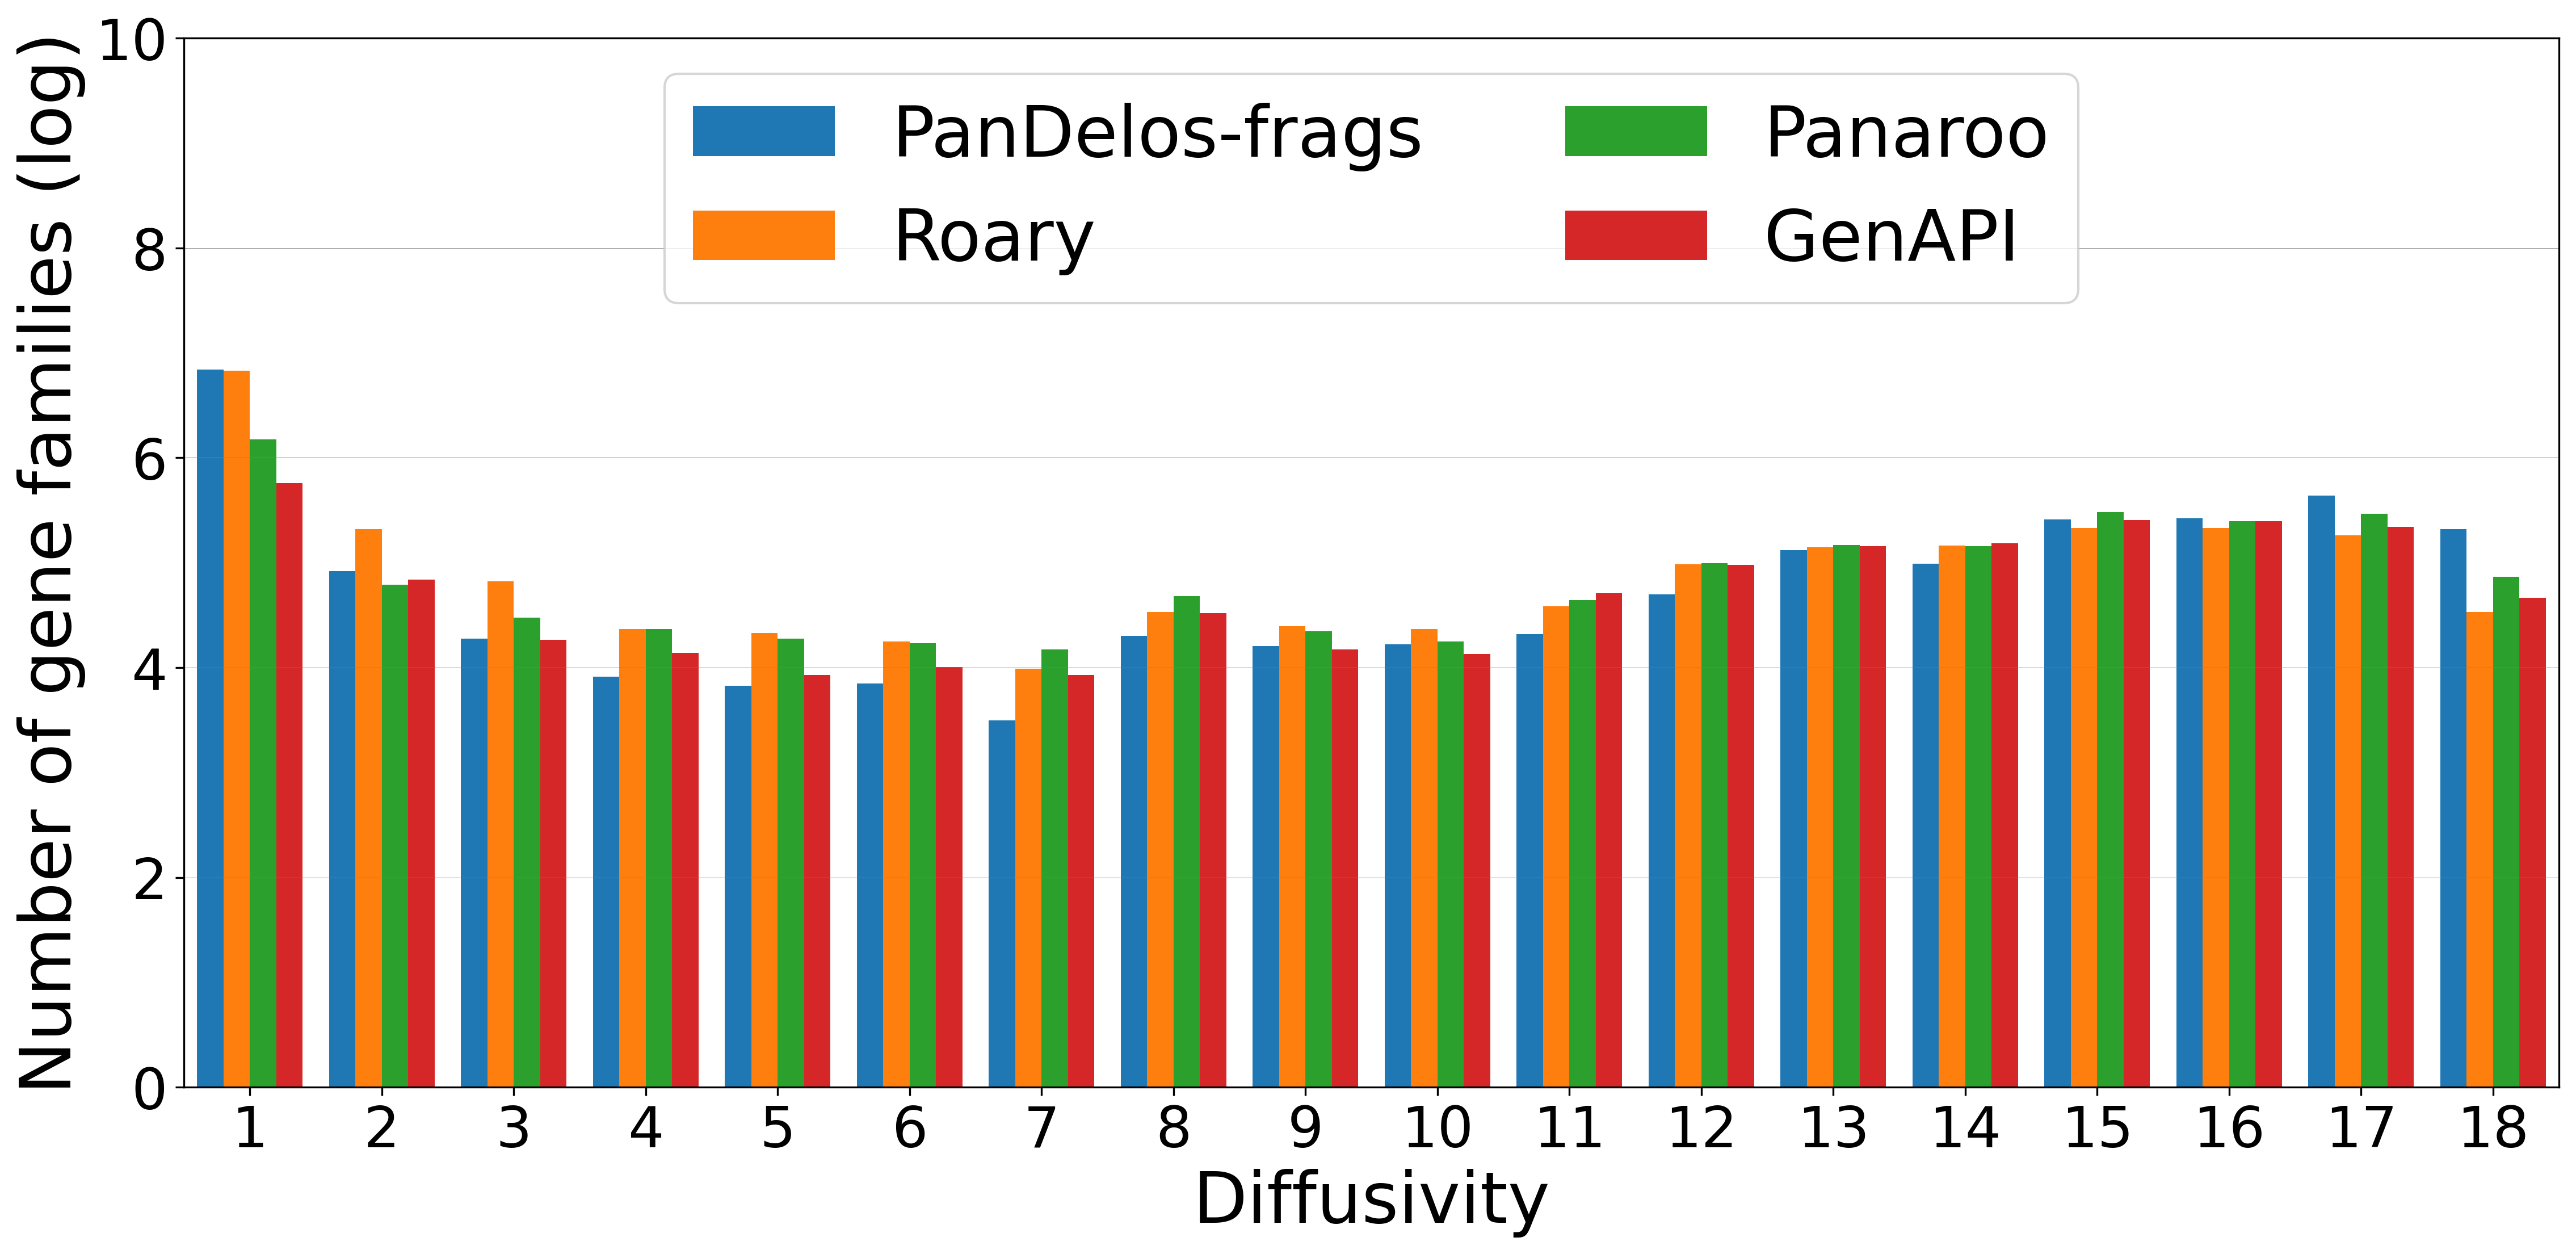

In [73]:
# set legend labels
pandelos_label='PanDelos-frags'
roary_label='Roary'
panaroo_label='Panaroo'
genapi_label='GenAPI'
labs=[pandelos_label,roary_label,panaroo_label,genapi_label]

# graphical parameters
fig, axe = plt.subplots(figsize=(len(delos),8), dpi=300)

plt.xlabel('Diffusivity',fontsize=30)
plt.ylabel('Number of gene families (log)',fontsize=30)  
plt.bar([l-0.3 for l in all_tools['GF Size']],np.log(all_tools['PanDelos-frags']),0.2,label='PanDelos-frags') 
plt.bar([l-0.1 for l in all_tools['GF Size']],np.log(all_tools['Roary']),0.2,label='Roary') 
plt.bar([l+0.1 for l in all_tools['GF Size']],np.log(all_tools['genapi']),0.2,label='GenAPI') 
plt.bar([l+0.3 for l in all_tools['GF Size']],np.log(all_tools['panaroo']),0.2,label='Panaroo') 

plt.grid(True, axis='y', color = "grey", linewidth = "0.2")
plt.xticks(list(all_tools['GF Size']),list(all_tools['GF Size']),fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0.5,max(all_tools['GF Size'])+0.5)
plt.ylim(0,10)
plt.legend(loc='upper center', fancybox=True, ncol=2,labels=labs,fontsize=30)
plt.show()

#plt.savefig(figdir+'/'+species+'_tools_comparison.svg', dpi=300,bbox_inches='tight')
